In [ ]:
import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# your model focuses on during captioning
import matplotlib.pyplot as plt

import collections
import random
import numpy as np
import os
import time
import json
from PIL import Image

In [ ]:
# Download caption annotation files
annotation_folder = '/annotations/'
if not os.path.exists(os.path.abspath('.') + annotation_folder):
  annotation_zip = tf.keras.utils.get_file('captions.zip',
                        cache_subdir=os.path.abspath('.'),
                        origin='http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                        extract=True)
  annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
  os.remove(annotation_zip)

# Download image files
image_folder = '/train2014/'
if not os.path.exists(os.path.abspath('.') + image_folder):
  image_zip = tf.keras.utils.get_file('train2014.zip',
                    cache_subdir=os.path.abspath('.'),
                    origin='http://images.cocodataset.org/zips/train2014.zip',
                    extract=True)
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)
else:
  PATH = os.path.abspath('.') + image_folder

13510574080/13510573713 [==============================] - 362s 0us/step


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
with open('/content/annotations/captions_train2014.json', 'r') as f:
    annotations = json.load(f)

In [ ]:
# Group all captions together having the same image ID.
image_path_to_caption = collections.defaultdict(list)
for val in annotations['annotations']:
  caption = f"<start> {val['caption']} <end>"
  image_path = "/content/train2014/" + 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
  image_path_to_caption[image_path].append(caption)

In [ ]:
len(image_path_to_caption.keys())

82783

In [ ]:
image_paths = list(image_path_to_caption.keys())
image_pathts_shuffle = image_paths[:-1]
print(image_paths[-1])
random.shuffle(image_pathts_shuffle)

# Select the first 6000 image_paths from the shuffled set.
# Approximately each image id has 5 captions associated with it, so that will
# lead to 30,000 examples.
train_image_paths = image_pathts_shuffle[50000:56000]#選6000張圖片出來，每張圖有5個句子-->30000句
print(len(train_image_paths))

6000


In [ ]:
train_captions = []#所有的圖片句子 length = 30019
img_name_vector = []#所有的圖片路徑 length = 30019

for image_path in train_image_paths:#對每個圖片路徑製作相對應的5個句子
  caption_list = image_path_to_caption[image_path]
  train_captions.extend(caption_list)
  img_name_vector.extend([image_path] * len(caption_list))

<start> there is a white toilet with the seat up here <end>


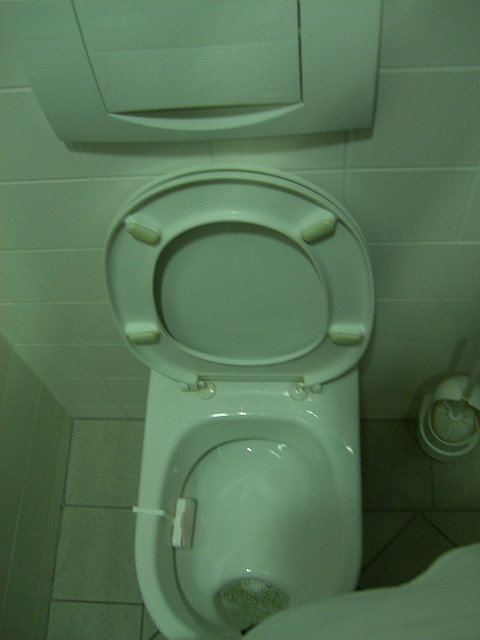

In [ ]:
print(train_captions[1])
Image.open(img_name_vector[0])

In [ ]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224, 224))
    img = tf.keras.applications.vgg19.preprocess_input(img)
    return img, image_path

In [ ]:
image_model = tf.keras.applications.VGG19(include_top=False,weights='imagenet')
                                                
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

80142336/80134624 [==============================] - 1s 0us/step


In [ ]:
!pip install tqdm

In [ ]:
from tqdm import tqdm
# Get unique images
encode_train = sorted(set(img_name_vector))#len = 6000圖片路徑

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)#(16,299,299,3) #(16,224,224,3)

for img, path in tqdm(image_dataset):
  batch_features = image_features_extract_model(img)#shape(16,7,7,512)
  batch_features = tf.reshape(batch_features,(batch_features.shape[0], -1, batch_features.shape[3]))#shape(16,49,512) 
                              

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())


100%|██████████| 375/375 [01:21<00:00,  4.63it/s]


In [ ]:
# Find the maximum length of any caption in the dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [ ]:
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,oov_token="<unk>",filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~')
tokenizer.fit_on_texts(train_captions)

tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

train_seqs = tokenizer.texts_to_sequences(train_captions)

cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')
max_length = calc_max_length(train_seqs)

## Split the data into training and testing

In [ ]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
  img_to_cap_vector[img].append(cap)

# Create training and validation sets using an 80-20 split randomly.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])

In [ ]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(24008, 24008, 6006, 6006)

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1  #5001
# label_size = 51
label_size = 60

num_steps = len(img_name_train) // BATCH_SIZE
# features_shape = 2048
features_shape = 512

attention_features_shape = 49

In [ ]:
# Load the numpy files
def map_func(imgpreprocess, img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return imgpreprocess, img_tensor, cap

In [ ]:
def load_image2(image_path,cap):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224, 224))
    img = tf.keras.applications.vgg19.preprocess_input(img)
    
    return img, image_path, cap

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))
dataset = dataset.map(load_image2)
dataset = dataset.map(lambda item1, item2, item3: tf.numpy_function(
          map_func, [item1, item2, item3], [tf.float32, tf.float32, tf.int32]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

## Model



In [ ]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):      #(64,64,256),(64,256)         
    
    hidden_with_time_axis = tf.expand_dims(hidden, 1)#(64,512)-->(64,1,512)

    #相加shape(64,64,512)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))) 

    #shape(64,64,1)
    score = self.V(attention_hidden_layer)      

    # attention_weights shape == (64, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)  

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features   #context_vector shape = (64,64,256)
    context_vector = tf.reduce_sum(context_vector, axis=1)#(64,64,256)-->(64,256)

    return context_vector, attention_weights        #output(64,256) (64,64,1)

In [ ]:
class CNN_Encoder(tf.keras.Model):      #1,64,256
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)      #(batch_size,64,256)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x        #input(64,64,2048)-->output(64,64,256)

In [ ]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)#5001

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):  #(64,1),(64,64,256),(64,512)  
    #feature_shape(64,64,256) hidden若用feature當h0(64,64,256)
    context_vector, attention_weights = self.attention(features, hidden)
    x = self.embedding(x)

    #context_vector(64,256)-->(64,1,256)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
    output, state = self.gru(x)

    x = self.fc1(output)
    x = tf.reshape(x, (-1, x.shape[2]))
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [ ]:
class FirstRNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(FirstRNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)#5001

    self.attention = BahdanauAttention(self.units)

    #第一個decoder的input是圖片label和初始dec_input<start>embedding後的總和
    #所以在first_RNNDecoder不用對dec_input做embedding，可以直接和context_vector做concat  
  def call(self, x, features, hidden):  
    context_vector, attention_weights = self.attention(features, hidden)

    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
    output, state = self.gru(x)

    x = self.fc1(output)

    x = tf.reshape(x, (-1, x.shape[2]))

    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [ ]:
encoder = CNN_Encoder(embedding_dim)
attention = BahdanauAttention(units)
first_decoder = FirstRNN_Decoder(embedding_dim, units, vocab_size)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## Checkpoint

In [ ]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [ ]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

In [ ]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [ ]:
#@tf.function
def train_step(img_tensor, target, label):
  loss = 0

  label_embedding = tf.keras.layers.Embedding(label_size,embedding_dim)
  embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
  hidden_init = tf.keras.layers.Dense(units)

  #設定hidden_state初始值
  hidden = img_tensor.numpy()       #用numpy把img_tensor的值取出來
  hidden = hidden.mean(axis = 1)    #取mean完後(64,2048)
  hidden= hidden_init(hidden)       #經過一次linear transform(64,512)

  #設定decoder_inut初始值
  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)  #(64,49)
  dec_input = embedding(dec_input)          #(64,1,256)
  
  #用img_preprocess預測該圖片的category 把它和第一個decoder_input<start>做embedding後相加當成新的decoder_input
  #label_pred = fintune_model.predict(img_preprocess)  #(64,1,60)
  #取每張圖片的label_pred最大值 (64,1)
  label = np.array(label)
  label = tf.expand_dims(label,1)
  label = label_embedding(label) #(64,1,256)
  #label = tf.data.Dataset.from_tensor_slices(label) #轉成dataset型態
  
  sum_dec_input = []
  for i in zip(label,dec_input):#求dec_input,label的和
    sum_dec_input.append(i[0].numpy()+i[1].numpy())
  sum_dec_input = np.array(sum_dec_input)

  with tf.GradientTape() as tape:
    features = encoder(img_tensor)    #shape = (64,64,2048)-->(64,64,256)

    for i in range(1, target.shape[1]):
      if i == 1:
        pred, next_hidden_state, _ = first_decoder(sum_dec_input, features, hidden)  
      else:
        pred, next_hidden_state, _ = decoder(dec_input,features,next_hidden_state)

      loss += loss_function(target[:, i], pred)

          # using teacher forcing
      dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [ ]:
def id_map_label(img_preprocess,model):#input是i[0]
  label = []
  result = model.predict(img_preprocess)#(64,50)
  for i in result:
    label.append(i.argmax())
  return label  #shape(64,1)  

In [ ]:
label

[1, 1, 46, 46, 1, 54, 42, 1, 46, 54, 1, 3, 9, 40]

In [ ]:
EPOCHS = 20  #20
finetune_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/datascience_final/vgg_multi_label60_ver3_25epoch_SGD.h5')

for epoch in range(start_epoch, EPOCHS):
  start = time.time()
  total_loss = 0
  
  for (batch,(img_preprocess,img_tensor,cap_target)) in enumerate(dataset):    
    #--todo--
    #經multi-label預測出結果後取出最大的數值並map回去取得category label
    label = id_map_label(img_preprocess,finetune_model)
    # 
    batch_loss, t_loss = train_step(img_tensor, cap_target, label)
    total_loss += t_loss

    if batch % 100 == 0:
      average_batch_loss = batch_loss.numpy()/int(cap_target.shape[1])
      print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
  loss_plot.append(total_loss / num_steps)

  if epoch % 5 == 0:
    ckpt_manager.save()

  print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
  print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 1 Batch 0 Loss 1.8779
Epoch 1 Batch 100 Loss 1.0940
Epoch 1 Batch 200 Loss 0.9482
Epoch 1 Batch 300 Loss 0.9423
Epoch 1 Loss 1.062238
Time taken for 1 epoch 596.35 sec

Epoch 2 Batch 0 Loss 0.9632
Epoch 2 Batch 100 Loss 0.8776
Epoch 2 Batch 200 Loss 0.9035
Epoch 2 Batch 300 Loss 0.8450
Epoch 2 Loss 0.895184
Time taken for 1 epoch 577.47 sec

Epoch 3 Batch 0 Loss 0.8996
Epoch 3 Batch 100 Loss 0.8186
Epoch 3 Batch 200 Loss 0.8850
Epoch 3 Batch 300 Loss 0.8335
Epoch 3 Loss 0.829362
Time taken for 1 epoch 571.38 sec

Epoch 4 Batch 0 Loss 0.8252
Epoch 4 Batch 100 Loss 0.8610
Epoch 4 Batch 200 Loss 0.7054
Epoch 4 Batch 300 Loss 0.8652
Epoch 4 Loss 0.783557
Time taken for 1 epoch 572.61 sec

Epoch 5 Batch 0 Loss 0.7311
Epoch 5 Batch 100 Loss 0.7387
Epoch 5 Batch 200 Loss 0.7385
Epoch 5 Batch 300 Loss 0.7222
Epoch 5 Loss 0.749569
Time taken for 1 epoch 570.50 sec

Epoch 6 Batch 0 Loss 0.7351
Epoch 6 Batch 100 Loss 0.7497
Epoch 6 Batch 200 Loss 0.6303
Epoch 6 Batch 300 Loss 0.7662
Epoch 6

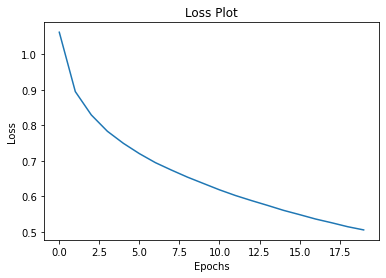

In [ ]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [ ]:
def evaluate(image):
    finetune_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/datascience_final/vgg_multi_label60_ver3_25epoch_SGD.h5')
    attention_plot = np.zeros((max_length, attention_features_shape))
    embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    hidden_init = tf.keras.layers.Dense(units)
    label_embedding = tf.keras.layers.Embedding(label_size,embedding_dim)

    img_preprocess,_ = load_image(image)#(299,299,3)
    img_preprocess = tf.expand_dims(img_preprocess, 0)#(1,299,299,3)

    img_tensor_val = image_features_extract_model(img_preprocess)#(64,8,8,2048)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],-1,img_tensor_val.shape[3]))#(64,64,2048)

    hidden = img_tensor_val.numpy()       
    hidden = hidden.mean(axis = 1) 
    hidden= hidden_init(hidden)#(1,512)

    features = encoder(img_tensor_val)

    label = id_map_label(img_preprocess,finetune_model)
    label = np.array(label)
    label = tf.expand_dims(label,1)
    label = label_embedding(label)#(1,1,256)
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)#(1,1)
    dec_input = embedding(dec_input)#(1,1,256)
    first_dec_input = dec_input.numpy()+label.numpy()

    result = []

    for i in range(max_length):
      if i == 0:
        predictions, hidden, attention_weights = first_decoder(first_dec_input, features, hidden)#(1.1.256),(1.64.256),(1,512)
      else:
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)                                                 

      attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

      predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
      result.append(tokenizer.index_word[predicted_id])

      if tokenizer.index_word[predicted_id] == '<end>':
          return result, attention_plot

      dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [ ]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(np.ceil(len_result/2), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

In [ ]:
for i in range(50):
  rid = np.random.randint(0, len(img_name_val))
  image = img_name_val[rid]
  print(image)

/content/train2014/COCO_train2014_000000069008.jpg
/content/train2014/COCO_train2014_000000407926.jpg
/content/train2014/COCO_train2014_000000137748.jpg
/content/train2014/COCO_train2014_000000109730.jpg
/content/train2014/COCO_train2014_000000562876.jpg
/content/train2014/COCO_train2014_000000301158.jpg
/content/train2014/COCO_train2014_000000036098.jpg
/content/train2014/COCO_train2014_000000578796.jpg
/content/train2014/COCO_train2014_000000383562.jpg
/content/train2014/COCO_train2014_000000217779.jpg
/content/train2014/COCO_train2014_000000118683.jpg
/content/train2014/COCO_train2014_000000485665.jpg
/content/train2014/COCO_train2014_000000164909.jpg
/content/train2014/COCO_train2014_000000402960.jpg
/content/train2014/COCO_train2014_000000232755.jpg
/content/train2014/COCO_train2014_000000070033.jpg
/content/train2014/COCO_train2014_000000500162.jpg
/content/train2014/COCO_train2014_000000060055.jpg
/content/train2014/COCO_train2014_000000506136.jpg
/content/train2014/COCO_train20

In [ ]:
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
print(image)

/content/train2014/COCO_train2014_000000362865.jpg


Real Caption: <start> a yellow and green fire hydrant sits near a grassy area <end>
Prediction Caption: consisting of blue <unk> in a field of red colored mouth <end>


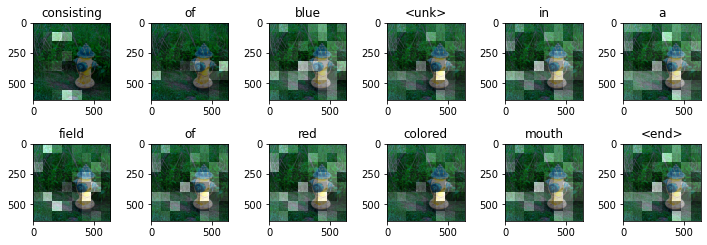

In [ ]:
# captions on the validation set
#rid = np.random.randint(0, len(img_name_val))
#image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

# BLEU

In [ ]:
#BLEU evaluation metrics
from nltk.translate.bleu_score import corpus_bleu

actual_captions = []
prediction_captions = []
actual_split=[]
image_list=[]
for i in range(len(img_name_val)):

  actual = ' '.join([tokenizer.index_word[j] for j in cap_val[i] if j not in [0]])
  actual_split.append(actual.split())
  image = img_name_val[i]
  
  # 5個caption對1個predict結果，所以同一張圖片的最後一個image再丟進evaluate就好
  if i < len(img_name_val)-1:
    if img_name_val[i] != img_name_val[i+1]:
      
      actual_captions.append(actual_split)
      #image_list.append(image)
      result ,attention_plot = evaluate(image)
      result.insert(0,'<start>')
      prediction_captions.append(result)
  elif i == len(img_name_val)-1:
    actual_captions.append(actual_split)
    result ,attention_plot = evaluate(image)
    result.insert(0,'<start>')
    prediction_captions.append(result)

print(len(actual_captions))
print(len(prediction_captions))
#print(len(image_list))

1199
1199


In [ ]:
from nltk.translate.bleu_score import corpus_bleu

print('BLEU-1: %f' % corpus_bleu(actual_captions,prediction_captions,weights=(1.0, 0, 0, 0)))
print('BLEU-2: %f' % corpus_bleu(actual_captions,prediction_captions,weights=(0.5, 0.5, 0, 0)))
print('BLEU-3: %f' % corpus_bleu(actual_captions,prediction_captions,weights=(0.3, 0.3, 0.3, 0)))
print('BLEU-4: %f' % corpus_bleu(actual_captions,prediction_captions,weights=(0.25, 0.25, 0.25, 0.25)))

BLEU-1: 0.834896
BLEU-2: 0.694788
BLEU-3: 0.556723
BLEU-4: 0.352598


In [ ]:
for img_preprocess,img_tensor,cap_target in dataset.take(1):
  pred =     finetune_model.predict(img_preprocess)

# 程式碼儲存格 <ADUO3SX3Y_14>
# #%% [code]
for i in pred:
  print(i.argsort()[-5:])


[29 42 58 57  1]
[44 46 42 54 43]
[40 50 42  1 46]
[57  1 42 46 40]
[16 17  9 24 38]
[59 58 38 50  1]
[58 50 40 42  1]
[40 46 42 58 57]
[44 46 40 42  1]
[25  2 31  3  1]
[46 52 42 43 54]
[ 4  6 27  3  1]
[27  8  6  3  1]
[25 28 31  3  1]
[27  8  1  6  3]
[46 40 43 42 54]
[10 14 31  1  3]
[26 31 38  9  1]
[16  5  3  6  1]
[43  5 29 12 24]
[10 20 21 24 23]
[57 40 58 42  1]
[46 59 58 42 40]
[27  8  6  3  1]
[31 38 49 43 40]
[14 10  6  1  3]
[ 4  6 27  3  1]
[39 36 33 35  1]
[46 42  4  3  1]
[40 50 42  1 46]
[33  5 30  3  1]
[46 40 57 42  1]
[32 57 36  3  1]
[44 46 42 43 54]
[33  3 57 39  1]
[52 40 54 42 46]
[ 5 30 31 38  1]
[40 57  1 46 42]
[ 7 31  5  3  1]
[14 42 40  3  1]
[16 35 50 36  1]
[50 14 58  3  1]
[10 20 21 24 23]
[14  7 28  3  1]
[46 59 58 42 40]
[ 1 31 10 12  3]
[ 6  1  7 10  3]
[31 27  1  6  3]
[31 25 27  3  1]
[42 46 57 58 40]
[57  1 42 46 40]
[52  7  5 23 24]
[27  8  6  3  1]
[18 17 30 20  9]
[40 46 42 58 57]
[ 9 43 42 46  1]
[31 38 49 43 40]
[39 36 33 35  1]
[14 10  6  1  